In [1]:
import numpy as np
import numpy.matlib
import pickle
import matplotlib.pyplot as plt
import scipy.linalg as sl
import time
import pathlib
import nbimporter  # I installed it for importing an .ipynb file into another .ipynb like the pilot_assignemnt

import pilot_assignment
import APLocation_Generation
import functionRlocalscattering
#------------------------------
#import Power_optimizers

import os

from datetime import datetime

from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy.linalg as l 


import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import time
import numpy.linalg as nl 


import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as Kr
from tensorflow.keras import initializers

import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


from __future__ import print_function
import keras
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils 

import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

C:\Users\afmb\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the non-negative input data x with b bits.

    Parameters:
    x (numpy array): Non-negative input data to be quantized
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data
    """
    
    x_max = np.max(np.abs(x))
    x_min = np.min(np.abs(x))
    R = x_max - x_min
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = R / (L-1)

    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [x_min, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min

    return quantized
#-----------------------------------------------------------------------------
def adaptive_signQuant_lambda(main_vector, dim, lambda_j, b_j):
    mynum = 0
    l_norm = np.linalg.norm(main_vector, ord=np.inf)
    
    # Normalize each element of the vector 
    normalized_x = np.abs(main_vector) / l_norm

    # Identify the indices where the normalized value is greater than or equal to lambda
    indices = np.where(normalized_x >= lambda_j)[0]
    non_indices = np.where(normalized_x < lambda_j)[0]

    # Count the number of positive and negative elements among these indices
    positive_elements = main_vector[indices] > 0
    negative_elements = main_vector[indices] < 0

    n_max = np.sum(positive_elements)
    n_min = np.sum(negative_elements)

    x = np.copy(main_vector)
    x_q = mynum*np.ones_like(x)#*np.sign(x)
    x_q_temp = np.zeros_like(x)

    # Quantize values where normalized_x >= lambda_j
    for i in indices:
        x_q_temp[i] = np.abs(x[i])
    x_q0 = uniform_quantization(x_q_temp, b_j)
    for i in indices:
        x_q[i] = np.sign(x[i]) * x_q0[i]

    if n_max > 0:
        largest_values_indices = np.argsort(x_q)[-n_max:]
        largest_values = x_q[largest_values_indices]
    else:
        largest_values_indices = np.array([], dtype=int)
        largest_values = np.array([], dtype=x_q.dtype)

    # Find the n_min smallest values and their indices
    if n_min > 0:
        smallest_values_indices = np.argsort(x_q)[:n_min]
        smallest_values = x_q[smallest_values_indices]
    else:
        smallest_values_indices = np.array([], dtype=int)
        smallest_values = np.array([], dtype=x_q.dtype)

    if largest_values.size > 0:
        x_max = np.min(largest_values)
    else:
        x_max = 0

    if smallest_values.size > 0:
        x_min = np.max(smallest_values)
    else:
        x_min = 0
    
    if np.abs(x_min) > 0 and x_max > 0:
        x_min_me = min(x_max, np.abs(x_min))
    else:
        x_min_me = max(x_max,0, np.abs(x_min))
    
    if x_min_me <  1e-10:
        x_min_me =  0.0001
    
    for i in range(len(main_vector)):
        if x_q[i] ==mynum:
            x_q[i] = (np.sign(x[i]) == 1)*x_min_me/2 - (np.sign(x[i]) == -1)*x_min_me/2
    
    x_quant = x_q
    err = main_vector - x_quant
    
    # Return the results
    return x_q, x_max, x_min, err, n_max, n_min, x_min_me 



In [13]:
# Load and preprocess the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Convert grayscale to RGB
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)    # Add channel dimension
x_train = np.repeat(x_train, 3, axis=-1)    # Convert grayscale to RGB
x_test = np.repeat(x_test, 3, axis=-1)      # Convert grayscale to RGB

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
K = 20



num_clients= K


np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class for controlled allocation
class_indices = {label: np.where(y_train == label)[0].tolist() for label in np.unique(y_train)}

# Precompute the number of samples per client and the class proportions for all clients
samples_per_client = len(x_train) // num_clients
num_classes = len(class_indices)
class_proportions = np.random.dirichlet(alpha=[0.8] * num_classes, size=num_clients)

# Allocate data to clients
client_data = []
for i in range(num_clients):
    x_client = []
    y_client = []

    # Allocate samples based on precomputed proportions
    for label in range(num_classes):
        indices = class_indices[label]
        if len(indices) == 0:
            continue  # Skip if no samples left for this class

        # Calculate number of samples to allocate for this class to this client
        num_samples = int(class_proportions[i][label] * samples_per_client)

        # Adjust to ensure we fill the client's quota exactly
        remaining_samples = samples_per_client - len(x_client)
        if len(x_client) + num_samples > samples_per_client:
            num_samples = remaining_samples

        # Ensure we don't allocate more samples than available
        num_samples = min(num_samples, len(indices))

        # Select samples for this client
        chosen_indices = indices[:num_samples]
        x_client.extend(x_train[chosen_indices])
        y_client.extend(y_train[chosen_indices])

        # Remove selected samples from the class
        class_indices[label] = indices[num_samples:]

        # Stop allocation if client's quota is filled
        if len(x_client) >= samples_per_client:
            break

    # Handle the case where we haven't filled the client quota due to rounding
    if len(x_client) < samples_per_client:
        for label in range(num_classes):
            indices = class_indices[label]
            if len(indices) == 0:
                continue
            needed_samples = samples_per_client - len(x_client)
            num_samples = min(needed_samples, len(indices))
            chosen_indices = indices[:num_samples]
            x_client.extend(x_train[chosen_indices])
            y_client.extend(y_train[chosen_indices])
            class_indices[label] = indices[num_samples:]
            if len(x_client) >= samples_per_client:
                break

    # Convert lists to numpy arrays
    x_client = np.array(x_client)
    y_client = np.array(y_client)

    # Shuffle the client's data to randomize order
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique.flatten(), counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data, labels = client_data[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#plot_client_data_distribution(client_data, num_clients)


Client 0: 3000 samples
Label distribution: {0: 44, 1: 1, 2: 350, 3: 275, 4: 512, 5: 77, 6: 164, 7: 938, 8: 559, 9: 80}

Client 1: 3000 samples
Label distribution: {0: 369, 1: 445, 2: 240, 3: 497, 4: 90, 5: 57, 6: 727, 7: 66, 8: 384, 9: 125}

Client 2: 3000 samples
Label distribution: {0: 182, 1: 1679, 2: 42, 3: 186, 4: 113, 5: 162, 6: 288, 7: 34, 8: 7, 9: 307}

Client 3: 3000 samples
Label distribution: {0: 21, 1: 126, 2: 4, 3: 65, 4: 555, 5: 1069, 6: 517, 7: 203, 8: 12, 9: 428}

Client 4: 3000 samples
Label distribution: {0: 117, 1: 372, 2: 259, 3: 6, 4: 51, 5: 98, 6: 20, 7: 160, 8: 1431, 9: 486}

Client 5: 3000 samples
Label distribution: {0: 504, 1: 178, 2: 94, 3: 414, 4: 310, 5: 208, 6: 148, 7: 814, 8: 295, 9: 35}

Client 6: 3000 samples
Label distribution: {0: 65, 1: 949, 2: 109, 3: 386, 4: 104, 5: 262, 6: 647, 7: 20, 8: 417, 9: 41}

Client 7: 3000 samples
Label distribution: {0: 257, 1: 53, 2: 172, 3: 162, 4: 1471, 5: 430, 6: 25, 7: 31, 8: 170, 9: 229}

Client 8: 3000 samples
Lab

In [7]:
x_train.shape

(60000, 28, 28)

In [14]:

# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 5 #local_epochs FedAvg
local_epochs = 5
epoch_increase = 0
b_j = 10
Lambda = 0.2**np.ones(K)



# Federated Averaging algorithm
num_global_iterations = 100
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Initialize the global model
global_model = create_model()

global_model.summary()

# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()


#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

Model: "sequential_448"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_448 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_448 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_448 (Flatten)        (None, 5408)              0         
_________________________________________________________________
dense_896 (Dense)            (None, 64)                346176    
_________________________________________________________________
dense_897 (Dense)            (None, 10)                650       
Total params: 347,722
Trainable params: 347,722
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 3s 10ms/step - loss: 2.3343 - accuracy: 0.1511
Initial Test Loss: 2.3

In [15]:
# Define the number of clients and local epochs


#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Split the data into non-overlapping portions for each client


# Initialize the global model
global_model = create_model()


# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

#----------------------------------------------------------------------------------------------

Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
#-----------------------------------------------------
t_start=time.time()
for k in range(num_global_iterations):
    N_total = 0
    
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            quantized_diff_local_global_weight_test_me = np.copy(diff_local_global_weight)
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(5408*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, max_model, min_model, err, n_max, n_min, x_min_me = adaptive_signQuant_lambda(Quantized_diff_local_global_weight, 
                                                                                                       Quantized_diff_local_global_weight.shape[0], Lambda[i], b_j)
            
            print('n_max:', n_max, 'n_min:', n_min, 'Lambda_j:', Lambda[i])
            N_total += n_max + n_min
            Bits[i,k] = (347722 - n_max - n_min) + (b_j+1)*(n_max + n_min)
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model:', 1*max_model, 'min_model:', 1*min_model, 'x_min_me:', x_min_me)
            percentage[i,k] = 100*(n_min+n_max)/347722
            print('percentage %:', percentage[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+5408*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(5408, 64)
                    dim_h+= 5408*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+640]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+10]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10,)
                    dim_h += 10
            
            
            local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    print('N_total:', N_total)
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
            
            

313/313 [==============================] - 2s 5ms/step - loss: 2.3123 - accuracy: 0.0656
Initial Test Loss: 2.3109
Initial Test Accuracy: 0.0718
Global Iteration 1/100
Client 1/20


C:\Users\afmb\AppData\Local\Temp\ipykernel_13136\4169798858.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights)


max: 0.34702014923095703 ----min: -0.3685312867164612
n_max: 930 n_min: 886 Lambda_j: 0.2
max error: 0.03692517774085126
max_model: 0.07385035559811784 min_model: -0.07385035559811784 x_min_me: 0.07385035559811784
percentage %: 0.5222562851933441
Client 2/20


C:\Users\afmb\AppData\Local\Temp\ipykernel_13136\4169798858.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))


max: 0.38803747296333313 ----min: -0.3614581227302551
n_max: 1066 n_min: 907 Lambda_j: 0.2
max error: 0.03887960971706344
max_model: 0.07775921989978817 min_model: -0.07775921989978817 x_min_me: 0.07775921989978817
percentage %: 0.5674072966335176
Client 3/20
max: 0.36537298560142517 ----min: -0.32434096932411194
n_max: 748 n_min: 563 Lambda_j: 0.2
max error: 0.036608729879635836
max_model: 0.0732174604577636 min_model: -0.0732174604577636 x_min_me: 0.0732174604577636
percentage %: 0.3770253248284549
Client 4/20
max: 0.31743624806404114 ----min: -0.4253096580505371
n_max: 541 n_min: 504 Lambda_j: 0.2
max error: 0.04261411436699615
max_model: 0.08522823059663745 min_model: -0.08522823059663745 x_min_me: 0.08522823059663745
percentage %: 0.30052743283427563
Client 5/20
max: 0.32794857025146484 ----min: -0.3217547535896301
n_max: 845 n_min: 632 Lambda_j: 0.2
max error: 0.03285897206354049
max_model: 0.06571794418528865 min_model: -0.06571794418528865 x_min_me: 0.06571794418528865
percenta

max: 0.19951006770133972 ----min: -0.18787212669849396
n_max: 1580 n_min: 1178 Lambda_j: 0.2
max error: 0.019990011656403434
max_model: 0.0399800233419107 min_model: -0.0399800233419107 x_min_me: 0.0399800233419107
percentage %: 0.7931623538343849
Client 12/20
max: 0.25252676010131836 ----min: -0.23205561935901642
n_max: 1241 n_min: 838 Lambda_j: 0.2
max error: 0.02530204582660011
max_model: 0.05060409171140788 min_model: -0.05060409171140788 x_min_me: 0.05060409171140788
percentage %: 0.5978914190071379
Client 13/20
max: 0.2189580798149109 ----min: -0.22656162083148956
n_max: 959 n_min: 684 Lambda_j: 0.2
max error: 0.02270045562605519
max_model: 0.045400911310318044 min_model: -0.045400911310318044 x_min_me: 0.045400911310318044
percentage %: 0.47250389679111476
Client 14/20
max: 0.26730918884277344 ----min: -0.29080089926719666
n_max: 1020 n_min: 871 Lambda_j: 0.2
max error: 0.029136942488351445
max_model: 0.058273884994892784 min_model: -0.058273884994892784 x_min_me: 0.058273884994

max: 0.15379750728607178 ----min: -0.10432250797748566
n_max: 223 n_min: 242 Lambda_j: 0.2
max error: 0.015484988514174182
max_model: 0.03096997702925786 min_model: -0.03096997702925786 x_min_me: 0.03096997702925786
percentage %: 0.13372751795974946
------------------------------------------------------------------------------------------------------
N_total: 51022
313/313 [==============================] - 3s 8ms/step - loss: 0.3806 - accuracy: 0.8640
Global Test loss: 0.3806, Global Test accuracy: 0.8640
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 0.3757 - accuracy: 0.8686
_FedAvg Global Test loss: 0.3757, _FedAvg Global Test accuracy: 0.8686
------------------------------------------------------------------------------------------------------
Global Iteration 4/100
Client 1/20
max: 0.14437231421470642 ----min: -0.1650090366601944
n_max: 2025 n_min: 2102 Lambda_j: 

max: 0.1404327005147934 ----min: -0.1219702959060669
n_max: 2194 n_min: 2022 Lambda_j: 0.2
max error: 0.014070725122165284
max_model: 0.028141450249787536 min_model: -0.028141450249787536 x_min_me: 0.028141450249787536
percentage %: 1.2124628295017283
Client 8/20
max: 0.1640424132347107 ----min: -0.16751211881637573
n_max: 1266 n_min: 1037 Lambda_j: 0.2
max error: 0.016783961063063103
max_model: 0.03356792214795408 min_model: -0.03356792214795408 x_min_me: 0.03356792214795408
percentage %: 0.6623106964759204
Client 9/20
max: 0.13295993208885193 ----min: -0.17535409331321716
n_max: 831 n_min: 694 Lambda_j: 0.2
max error: 0.017569691641953225
max_model: 0.03513938331301028 min_model: -0.03513938331301028 x_min_me: 0.03513938331301028
percentage %: 0.4385687416959525
Client 10/20
max: 0.1394670009613037 ----min: -0.13350670039653778
n_max: 1606 n_min: 1611 Lambda_j: 0.2
max error: 0.013973966364702177
max_model: 0.02794793274395627 min_model: -0.02794793274395627 x_min_me: 0.0279479327439

max: 0.1821904182434082 ----min: -0.12144836038351059
n_max: 1426 n_min: 1227 Lambda_j: 0.2
max error: 0.018254660663523346
max_model: 0.036509321348874565 min_model: -0.036509321348874565 x_min_me: 0.036509321348874565
percentage %: 0.7629658175208931
Client 17/20
max: 0.23950313031673431 ----min: -0.18721343576908112
n_max: 739 n_min: 799 Lambda_j: 0.2
max error: 0.02399713669851286
max_model: 0.04799427342612955 min_model: -0.04799427342612955 x_min_me: 0.04799427342612955
percentage %: 0.4423073604776229
Client 18/20
max: 0.22206687927246094 ----min: -0.21508458256721497
n_max: 584 n_min: 622 Lambda_j: 0.2
max error: 0.022250102703695807
max_model: 0.044500205523806936 min_model: -0.044500205523806936 x_min_me: 0.044500205523806936
percentage %: 0.3468287885149631
Client 19/20
max: 0.20498055219650269 ----min: -0.14845460653305054
n_max: 806 n_min: 678 Lambda_j: 0.2
max error: 0.020538129604354756
max_model: 0.04107625923781334 min_model: -0.04107625923781334 x_min_me: 0.0410762592

max: 0.12355369329452515 ----min: -0.12335148453712463
n_max: 2115 n_min: 2214 Lambda_j: 0.2
max error: 0.012379524480107677
max_model: 0.02475904899841413 min_model: -0.02475904899841413 x_min_me: 0.02475904899841413
percentage %: 1.2449600542962482
Client 4/20
max: 0.13410352170467377 ----min: -0.17271189391613007
n_max: 779 n_min: 685 Lambda_j: 0.2
max error: 0.017304955041359194
max_model: 0.03460991031554903 min_model: -0.03460991031554903 x_min_me: 0.03460991031554903
percentage %: 0.4210259920281144
Client 5/20
max: 0.1197100281715393 ----min: -0.10825635492801666
n_max: 947 n_min: 877 Lambda_j: 0.2
max error: 0.011994406508122737
max_model: 0.023988813074453136 min_model: -0.023988813074453136 x_min_me: 0.023988813074453136
percentage %: 0.524556973674372
Client 6/20
max: 0.12627771496772766 ----min: -0.1263347864151001
n_max: 3626 n_min: 3214 Lambda_j: 0.2
max error: 0.012658177408069293
max_model: 0.02531635504896923 min_model: -0.02531635504896923 x_min_me: 0.025316355048969

max: 0.1538868248462677 ----min: -0.14480671286582947
n_max: 2178 n_min: 1989 Lambda_j: 0.2
max error: 0.015418767827171066
max_model: 0.030837535770757454 min_model: -0.030837535770757454 x_min_me: 0.030837535770757454
percentage %: 1.1983711125554322
Client 13/20
max: 0.16499149799346924 ----min: -0.16412092745304108
n_max: 479 n_min: 432 Lambda_j: 0.2
max error: 0.01653140614348403
max_model: 0.03306281240338338 min_model: -0.03306281240338338 x_min_me: 0.03306281240338338
percentage %: 0.26199090077705756
Client 14/20
max: 0.13448438048362732 ----min: -0.1252909004688263
n_max: 3781 n_min: 4128 Lambda_j: 0.2
max error: 0.013474729972029377
max_model: 0.02694946040972004 min_model: -0.02694946040972004 x_min_me: 0.02694946040972004
percentage %: 2.2745181495562545
Client 15/20
max: 0.13703373074531555 ----min: -0.16042955219745636
n_max: 1273 n_min: 1015 Lambda_j: 0.2
max error: 0.016074319513248808
max_model: 0.032148639492158904 min_model: -0.032148639492158904 x_min_me: 0.0321486

------------------------------------------------------------------------------------------------------
N_total: 55448
313/313 [==============================] - 3s 8ms/step - loss: 0.3783 - accuracy: 0.8877
Global Test loss: 0.3783, Global Test accuracy: 0.8877
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 0.3619 - accuracy: 0.8893
_FedAvg Global Test loss: 0.3619, _FedAvg Global Test accuracy: 0.8893
------------------------------------------------------------------------------------------------------
Global Iteration 11/100
Client 1/20
max: 0.11201211810112 ----min: -0.12844711542129517
n_max: 3137 n_min: 3293 Lambda_j: 0.2
max error: 0.01286982315982112
max_model: 0.02573964678530353 min_model: -0.02573964678530353 x_min_me: 0.02573964678530353
percentage %: 1.849178366626213
Client 2/20
max: 0.16401809453964233 ----min: -0.1272621750831604
n_max: 2307 n_min: 1948 L

n_max: 1297 n_min: 1130 Lambda_j: 0.2
max error: 0.014640142513099487
max_model: 0.029280285259029617 min_model: -0.029280285259029617 x_min_me: 0.029280285259029617
percentage %: 0.6979713679318537
Client 8/20
max: 0.12595532834529877 ----min: -0.12933513522148132
n_max: 2011 n_min: 1769 Lambda_j: 0.2
max error: 0.012958798939923761
max_model: 0.025917597967159013 min_model: -0.025917597967159013 x_min_me: 0.025917597967159013
percentage %: 1.0870753072857053
Client 9/20
max: 0.12159712612628937 ----min: -0.11445224285125732
n_max: 1466 n_min: 1130 Lambda_j: 0.2
max error: 0.012183485150392753
max_model: 0.02436697053361615 min_model: -0.02436697053361615 x_min_me: 0.02436697053361615
percentage %: 0.746573412093569
Client 10/20
max: 0.10447794198989868 ----min: -0.13985849916934967
n_max: 955 n_min: 690 Lambda_j: 0.2
max error: 0.014013192644710348
max_model: 0.02802638546404368 min_model: -0.02802638546404368 x_min_me: 0.02802638546404368
percentage %: 0.47307906891137175
Client 11/

max: 0.15496870875358582 ----min: -0.18116652965545654
n_max: 1066 n_min: 771 Lambda_j: 0.2
max error: 0.01815207152550481
max_model: 0.03630414328384026 min_model: -0.03630414328384026 x_min_me: 0.03630414328384026
percentage %: 0.5282955924560425
Client 17/20
max: 0.15137454867362976 ----min: -0.14406582713127136
n_max: 2253 n_min: 2460 Lambda_j: 0.2
max error: 0.01516704894945684
max_model: 0.030334098219055815 min_model: -0.030334098219055815 x_min_me: 0.030334098219055815
percentage %: 1.3553931013855895
Client 18/20
max: 0.1364985704421997 ----min: -0.17182397842407227
n_max: 840 n_min: 728 Lambda_j: 0.2
max error: 0.017215989959844545
max_model: 0.03443198003610441 min_model: -0.03443198003610441 x_min_me: 0.03443198003610441
percentage %: 0.45093494228147774
Client 19/20
max: 0.15448269248008728 ----min: -0.10894554853439331
n_max: 1699 n_min: 1308 Lambda_j: 0.2
max error: 0.01547847107016217
max_model: 0.030956942285843492 min_model: -0.030956942285843492 x_min_me: 0.030956942

n_max: 1411 n_min: 1244 Lambda_j: 0.2
max error: 0.017408862418790083
max_model: 0.03481772507041081 min_model: -0.03481772507041081 x_min_me: 0.03481772507041081
percentage %: 0.7635409896411501
Client 3/20
max: 0.10540860891342163 ----min: -0.09586137533187866
n_max: 2407 n_min: 2204 Lambda_j: 0.2
max error: 0.010561468431293438
max_model: 0.0211229372700405 min_model: -0.0211229372700405 x_min_me: 0.0211229372700405
percentage %: 1.3260593232524833
Client 4/20
max: 0.14174121618270874 ----min: -0.15904803574085236
n_max: 517 n_min: 352 Lambda_j: 0.2
max error: 0.015935897776394543
max_model: 0.031871796018450374 min_model: -0.031871796018450374 x_min_me: 0.031871796018450374
percentage %: 0.24991228625166081
Client 5/20
max: 0.10857772827148438 ----min: -0.14342454075813293
n_max: 282 n_min: 198 Lambda_j: 0.2
max error: 0.014370494056955348
max_model: 0.02874098812846261 min_model: -0.02874098812846261 x_min_me: 0.02874098812846261
percentage %: 0.13804130886167687
Client 6/20
max: 

max: 0.13221678137779236 ----min: -0.170785054564476
n_max: 359 n_min: 360 Lambda_j: 0.2
max error: 0.017111894286092905
max_model: 0.0342237890378471 min_model: -0.0342237890378471 x_min_me: 0.0342237890378471
percentage %: 0.20677437723238679
Client 12/20
max: 0.12230688333511353 ----min: -0.13963213562965393
n_max: 2273 n_min: 2079 Lambda_j: 0.2
max error: 0.013990511944944833
max_model: 0.02798102424641159 min_model: -0.02798102424641159 x_min_me: 0.02798102424641159
percentage %: 1.2515745336792035
Client 13/20
max: 0.14529544115066528 ----min: -0.1395477056503296
n_max: 394 n_min: 388 Lambda_j: 0.2
max error: 0.01455794975449689
max_model: 0.029115899741824422 min_model: -0.029115899741824422 x_min_me: 0.029115899741824422
percentage %: 0.22489229902048188
Client 14/20
max: 0.11250367760658264 ----min: -0.11890225112438202
n_max: 4282 n_min: 4578 Lambda_j: 0.2
max error: 0.011913470894782549
max_model: 0.02382694181866893 min_model: -0.02382694181866893 x_min_me: 0.02382694181866

max: 0.13471591472625732 ----min: -0.08423945307731628
n_max: 123 n_min: 71 Lambda_j: 0.2
max error: 0.01349792885120386
max_model: 0.026995857789719212 min_model: -0.026995857789719212 x_min_me: 0.026995857789719212
percentage %: 0.055791695664927726
------------------------------------------------------------------------------------------------------
N_total: 49585
313/313 [==============================] - 1s 5ms/step - loss: 0.4167 - accuracy: 0.8974
Global Test loss: 0.4167, Global Test accuracy: 0.8974
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 1s 5ms/step - loss: 0.3853 - accuracy: 0.8965
_FedAvg Global Test loss: 0.3853, _FedAvg Global Test accuracy: 0.8965
------------------------------------------------------------------------------------------------------
Global Iteration 18/100
Client 1/20
max: 0.11022049188613892 ----min: -0.13683770596981049
n_max: 1902 n_min: 2024 Lambda

n_max: 1583 n_min: 1534 Lambda_j: 0.2
max error: 0.013183682013560738
max_model: 0.026367364099881052 min_model: -0.026367364099881052 x_min_me: 0.026367364099881052
percentage %: 0.8964057494205141
Client 7/20
max: 0.1194462776184082 ----min: -0.1408795714378357
n_max: 1023 n_min: 929 Lambda_j: 0.2
max error: 0.014115499407369352
max_model: 0.02823099916398467 min_model: -0.02823099916398467 x_min_me: 0.02823099916398467
percentage %: 0.5613679893708192
Client 8/20
max: 0.1725403070449829 ----min: -0.12080803513526917
n_max: 452 n_min: 356 Lambda_j: 0.2
max error: 0.017287762808424117
max_model: 0.03457552584967888 min_model: -0.03457552584967888 x_min_me: 0.03457552584967888
percentage %: 0.2323695365838227
Client 9/20
max: 0.1289093941450119 ----min: -0.11610281467437744
n_max: 671 n_min: 538 Lambda_j: 0.2
max error: 0.01291614140926488
max_model: 0.025832283284191047 min_model: -0.025832283284191047 x_min_me: 0.025832283284191047
percentage %: 0.3476915466953486
Client 10/20
max: 0

max: 0.11933323740959167 ----min: -0.09666863083839417
n_max: 2277 n_min: 2073 Lambda_j: 0.2
max error: 0.011956653331487438
max_model: 0.02391330759429745 min_model: -0.02391330759429745 x_min_me: 0.02391330759429745
percentage %: 1.2509993615589465
Client 16/20
max: 0.1404857039451599 ----min: -0.220431849360466
n_max: 396 n_min: 250 Lambda_j: 0.2
max error: 0.022086280058554574
max_model: 0.04417256023352447 min_model: -0.04417256023352447 x_min_me: 0.04417256023352447
percentage %: 0.18578059484300677
Client 17/20
max: 0.14891529083251953 ----min: -0.14382562041282654
n_max: 1906 n_min: 2109 Lambda_j: 0.2
max error: 0.01492064160077249
max_model: 0.029841285064190128 min_model: -0.029841285064190128 x_min_me: 0.029841285064190128
percentage %: 1.1546580314159012
Client 18/20
max: 0.16070914268493652 ----min: -0.2374870479106903
n_max: 181 n_min: 167 Lambda_j: 0.2
max error: 0.02379513408862171
max_model: 0.04759026864290471 min_model: -0.04759026864290471 x_min_me: 0.04759026864290

n_max: 1373 n_min: 1446 Lambda_j: 0.2
max error: 0.014203468820208242
max_model: 0.02840693774227989 min_model: -0.02840693774227989 x_min_me: 0.02840693774227989
percentage %: 0.810705103502223
Client 2/20
max: 0.12682735919952393 ----min: -0.1558350920677185
n_max: 1777 n_min: 1542 Lambda_j: 0.2
max error: 0.015613975471327398
max_model: 0.031227951000862456 min_model: -0.031227951000862456 x_min_me: 0.031227951000862456
percentage %: 0.9544981335664697
Client 3/20
max: 0.11447298526763916 ----min: -0.1325034499168396
n_max: 697 n_min: 739 Lambda_j: 0.2
max error: 0.013276249854926148
max_model: 0.026552499738956126 min_model: -0.026552499738956126 x_min_me: 0.026552499738956126
percentage %: 0.4129735823445166
Client 4/20
max: 0.1078539788722992 ----min: -0.1141977310180664
n_max: 1210 n_min: 1012 Lambda_j: 0.2
max error: 0.011442099032511175
max_model: 0.022884198297852994 min_model: -0.022884198297852994 x_min_me: 0.022884198297852994
percentage %: 0.6390162256055124
Client 5/20
m

max: 0.12030696868896484 ----min: -0.12296818941831589
n_max: 794 n_min: 763 Lambda_j: 0.2
max error: 0.012320859527159828
max_model: 0.0246417192871503 min_model: -0.0246417192871503 x_min_me: 0.0246417192871503
percentage %: 0.4477714956200643
Client 11/20
max: 0.12173697352409363 ----min: -0.1415105164051056
n_max: 491 n_min: 409 Lambda_j: 0.2
max error: 0.014178717314203764
max_model: 0.028357434861238172 min_model: -0.028357434861238172 x_min_me: 0.028357434861238172
percentage %: 0.2588274541156441
Client 12/20
max: 0.10857720673084259 ----min: -0.11348412185907364
n_max: 2875 n_min: 3075 Lambda_j: 0.2
max error: 0.011370598705443245
max_model: 0.02274119743999032 min_model: -0.02274119743999032 x_min_me: 0.02274119743999032
percentage %: 1.711137057764536
Client 13/20
max: 0.0891508236527443 ----min: -0.11244295537471771
n_max: 480 n_min: 422 Lambda_j: 0.2
max error: 0.011266278287119078
max_model: 0.022532557039899443 min_model: -0.022532557039899443 x_min_me: 0.022532557039899

max: 0.13210329413414001 ----min: -0.11424222588539124
n_max: 1750 n_min: 1824 Lambda_j: 0.2
max error: 0.013236156058474035
max_model: 0.02647231211876706 min_model: -0.02647231211876706 x_min_me: 0.02647231211876706
percentage %: 1.0278325788992355
Client 20/20
max: 0.14849768579006195 ----min: -0.06830453872680664
n_max: 110 n_min: 44 Lambda_j: 0.2
max error: 0.014878800379177782
max_model: 0.0297576007692695 min_model: -0.03048339590998339 x_min_me: 0.0297576007692695
percentage %: 0.04428825325978799
------------------------------------------------------------------------------------------------------
N_total: 42395
313/313 [==============================] - 2s 7ms/step - loss: 0.4696 - accuracy: 0.8968
Global Test loss: 0.4696, Global Test accuracy: 0.8968
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 8ms/step - loss: 0.4102 - accuracy: 0.8979
_FedAvg Global Test loss: 0.4102, _F

n_max: 413 n_min: 451 Lambda_j: 0.2
max error: 0.012835597129684772
max_model: 0.025671194375784866 min_model: -0.025671194375784866 x_min_me: 0.025671194375784866
percentage %: 0.24847435595101836
Client 6/20
max: 0.12164373695850372 ----min: -0.1133301705121994
n_max: 1338 n_min: 1299 Lambda_j: 0.2
max error: 0.012188155229776034
max_model: 0.024376310925213356 min_model: -0.024376310925213356 x_min_me: 0.024376310925213356
percentage %: 0.7583644405588372
Client 7/20
max: 0.10768121480941772 ----min: -0.17234143614768982
n_max: 334 n_min: 307 Lambda_j: 0.2
max error: 0.01726783672233867
max_model: 0.03453567391033863 min_model: -0.03453567391033863 x_min_me: 0.03453567391033863
percentage %: 0.1843426645423643
Client 8/20
max: 0.15064087510108948 ----min: -0.10937333106994629
n_max: 809 n_min: 646 Lambda_j: 0.2
max error: 0.015093538287476494
max_model: 0.03018707663316065 min_model: -0.03018707663316065 x_min_me: 0.03018707663316065
percentage %: 0.41843771748695796
Client 9/20
max

max: 0.13737648725509644 ----min: -0.13934284448623657
n_max: 2144 n_min: 2035 Lambda_j: 0.2
max error: 0.013961526335040443
max_model: 0.02792305290291153 min_model: -0.02792305290291153 x_min_me: 0.02792305290291153
percentage %: 1.2018221452769742
Client 15/20
max: 0.13184991478919983 ----min: -0.13528689742088318
n_max: 987 n_min: 892 Lambda_j: 0.2
max error: 0.013555137862069922
max_model: 0.027110277586784994 min_model: -0.027110277586784994 x_min_me: 0.027110277586784994
percentage %: 0.5403742069814392
Client 16/20
max: 0.1730770319700241 ----min: -0.11427769064903259
n_max: 493 n_min: 309 Lambda_j: 0.2
max error: 0.017341540305246962
max_model: 0.034683080697805416 min_model: -0.034683080697805416 x_min_me: 0.034683080697805416
percentage %: 0.23064402022305175
Client 17/20
max: 0.14470219612121582 ----min: -0.12705591320991516
n_max: 1763 n_min: 1839 Lambda_j: 0.2
max error: 0.014498509153703688
max_model: 0.028997018773068664 min_model: -0.028997018773068664 x_min_me: 0.0289

max: 0.11736595630645752 ----min: -0.1019141674041748
n_max: 1830 n_min: 1677 Lambda_j: 0.2
max error: 0.011759540998432424
max_model: 0.023519082153297937 min_model: -0.023519082153297937 x_min_me: 0.023519082153297937
percentage %: 1.0085643128706265
Client 2/20
max: 0.1194380521774292 ----min: -0.1352890133857727
n_max: 1926 n_min: 1606 Lambda_j: 0.2
max error: 0.013555350774455995
max_model: 0.02711070160711965 min_model: -0.02711070160711965 x_min_me: 0.02711070160711965
percentage %: 1.015753964373839
Client 3/20
max: 0.09524697065353394 ----min: -0.17310573160648346
n_max: 303 n_min: 260 Lambda_j: 0.2
max error: 0.017344415908873846
max_model: 0.03468883184685152 min_model: -0.03468883184685152 x_min_me: 0.03468883184685152
percentage %: 0.1619109518523418
Client 4/20
max: 0.11326777935028076 ----min: -0.08952027559280396
n_max: 1218 n_min: 927 Lambda_j: 0.2
max error: 0.011348922056999906
max_model: 0.022697844346830455 min_model: -0.022697844346830455 x_min_me: 0.0226978443468

max: 0.09985598921775818 ----min: -0.08906595408916473
n_max: 1133 n_min: 1228 Lambda_j: 0.2
max error: 0.01000512099289085
max_model: 0.020010242218612345 min_model: -0.020010242218612345 x_min_me: 0.020010242218612345
percentage %: 0.678990687963373
Client 11/20
max: 0.12592649459838867 ----min: -0.11811681091785431
n_max: 655 n_min: 663 Lambda_j: 0.2
max error: 0.01261726846215875
max_model: 0.02523453704073282 min_model: -0.02523453704073282 x_min_me: 0.02523453704073282
percentage %: 0.3790384272493544
Client 12/20
max: 0.1141863763332367 ----min: -0.11105282604694366
n_max: 2867 n_min: 2905 Lambda_j: 0.2
max error: 0.011440960994902508
max_model: 0.02288192292112759 min_model: -0.02288192292112759 x_min_me: 0.02288192292112759
percentage %: 1.6599467390616642
Client 13/20
max: 0.11008533835411072 ----min: -0.14276480674743652
n_max: 166 n_min: 211 Lambda_j: 0.2
max error: 0.014304391624697758
max_model: 0.028748338406619674 min_model: -0.02860878336581084 x_min_me: 0.028608783365

max: 0.16326257586479187 ----min: -0.17201828956604004
n_max: 498 n_min: 412 Lambda_j: 0.2
max error: 0.017235459091638206
max_model: 0.03447091824148407 min_model: -0.03447091824148407 x_min_me: 0.03447091824148407
percentage %: 0.26170331471692904
Client 20/20
max: 0.14571937918663025 ----min: -0.12897434830665588
n_max: 174 n_min: 105 Lambda_j: 0.2
max error: 0.014600426541293248
max_model: 0.029200853111690326 min_model: -0.029200853111690326 x_min_me: 0.029200853111690326
percentage %: 0.08023651077584967
------------------------------------------------------------------------------------------------------
N_total: 37573
313/313 [==============================] - 2s 5ms/step - loss: 0.6068 - accuracy: 0.8806
Global Test loss: 0.6068, Global Test accuracy: 0.8806
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 0.4402 - accuracy: 0.8964
_FedAvg Global Test loss: 0.440

n_max: 549 n_min: 499 Lambda_j: 0.2
max error: 0.01060351222502714
max_model: 0.021207024682884924 min_model: -0.021207024682884924 x_min_me: 0.021207024682884924
percentage %: 0.30139019101466114
Client 6/20
max: 0.12964990735054016 ----min: -0.11908790469169617
n_max: 1179 n_min: 1056 Lambda_j: 0.2
max error: 0.012990337502682912
max_model: 0.02598067547102711 min_model: -0.02598067547102711 x_min_me: 0.02598067547102711
percentage %: 0.6427548443871829
Client 7/20
max: 0.1172361969947815 ----min: -0.1627664864063263
n_max: 323 n_min: 467 Lambda_j: 0.2
max error: 0.016308469579938367
max_model: 0.03261694009119931 min_model: -0.03261694009119931 x_min_me: 0.03261694009119931
percentage %: 0.22719298750150982
Client 8/20
max: 0.12497594952583313 ----min: -0.10351738333702087
n_max: 1078 n_min: 968 Lambda_j: 0.2
max error: 0.012522027974570249
max_model: 0.025044056356594124 min_model: -0.025044056356594124 x_min_me: 0.025044056356594124
percentage %: 0.5884010790228976
Client 9/20
max

max: 0.15051022171974182 ----min: -0.14745312929153442
n_max: 1344 n_min: 1520 Lambda_j: 0.2
max error: 0.015080447260639517
max_model: 0.030160894870525 min_model: -0.030160894870525 x_min_me: 0.030160894870525
percentage %: 0.8236464762080052
Client 15/20
max: 0.1444454789161682 ----min: -0.11338900029659271
n_max: 512 n_min: 455 Lambda_j: 0.2
max error: 0.01447278746238576
max_model: 0.028945574953875352 min_model: -0.028945574953875352 x_min_me: 0.028945574953875352
percentage %: 0.27809572014425316
Client 16/20
max: 0.1158568412065506 ----min: -0.10434442013502121
n_max: 1554 n_min: 1331 Lambda_j: 0.2
max error: 0.011608334413077773
max_model: 0.02321666905898619 min_model: -0.02321666905898619 x_min_me: 0.02321666905898619
percentage %: 0.8296857834707037
Client 17/20
max: 0.1200663149356842 ----min: -0.12388661503791809
n_max: 2316 n_min: 2376 Lambda_j: 0.2
max error: 0.012412881528055577
max_model: 0.024825763521772442 min_model: -0.024825763521772442 x_min_me: 0.02482576352177

max: 0.10967248678207397 ----min: -0.13738831877708435
n_max: 1373 n_min: 1386 Lambda_j: 0.2
max error: 0.013765691756801408
max_model: 0.02753138352815473 min_model: -0.02753138352815473 x_min_me: 0.02753138352815473
percentage %: 0.7934499398945134
Client 2/20
max: 0.12337571382522583 ----min: -0.12397445738315582
n_max: 1879 n_min: 1781 Lambda_j: 0.2
max error: 0.012421682703227738
max_model: 0.02484336633777805 min_model: -0.02484336633777805 x_min_me: 0.02484336633777805
percentage %: 1.052564980070286
Client 3/20
max: 0.11708924174308777 ----min: -0.08954629302024841
n_max: 723 n_min: 824 Lambda_j: 0.2
max error: 0.011731815405252807
max_model: 0.023463631043336257 min_model: -0.023463631043336257 x_min_me: 0.023463631043336257
percentage %: 0.4448956350187794
Client 4/20
max: 0.10458415746688843 ----min: -0.12282484769821167
n_max: 679 n_min: 639 Lambda_j: 0.2
max error: 0.0123064974186642
max_model: 0.02461299489553606 min_model: -0.02461299489553606 x_min_me: 0.024612994895536

max: 0.13449758291244507 ----min: -0.16882257163524628
n_max: 78 n_min: 70 Lambda_j: 0.2
max error: 0.016915262540685976
max_model: 0.0338305251077473 min_model: -0.0338305251077473 x_min_me: 0.0338305251077473
percentage %: 0.04256273689901703
Client 11/20
max: 0.1344531774520874 ----min: -0.12828600406646729
n_max: 388 n_min: 564 Lambda_j: 0.2
max error: 0.013471603743198945
max_model: 0.026943207602813213 min_model: -0.026943207602813213 x_min_me: 0.026943207602813213
percentage %: 0.27378192924232575
Client 12/20
max: 0.13394702970981598 ----min: -0.1137840747833252
n_max: 1542 n_min: 1593 Lambda_j: 0.2
max error: 0.01342088984073352
max_model: 0.026841780147128326 min_model: -0.026841780147128326 x_min_me: 0.026841780147128326
percentage %: 0.901582298502827
Client 13/20
max: 0.09505701065063477 ----min: -0.09879761934280396
n_max: 396 n_min: 439 Lambda_j: 0.2
max error: 0.009899077204605448
max_model: 0.01979815441375837 min_model: -0.01979815441375837 x_min_me: 0.019798154413758

max: 0.17496618628501892 ----min: -0.12179563194513321
n_max: 267 n_min: 231 Lambda_j: 0.2
max error: 0.017530825058326493
max_model: 0.03506165023306831 min_model: -0.03506165023306831 x_min_me: 0.03506165023306831
percentage %: 0.14321785794398975
Client 20/20
max: 0.13184523582458496 ----min: -0.07850438356399536
n_max: 147 n_min: 272 Lambda_j: 0.2
max error: 0.013210299762593695
max_model: 0.02642059955429122 min_model: -0.02642059955429122 x_min_me: 0.02642059955429122
percentage %: 0.12049855919383876
------------------------------------------------------------------------------------------------------
N_total: 29665
313/313 [==============================] - 2s 5ms/step - loss: 0.6116 - accuracy: 0.8921
Global Test loss: 0.6116, Global Test accuracy: 0.8921
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 0.4686 - accuracy: 0.8956
_FedAvg Global Test loss: 0.4686, 

max: 0.1518283635377884 ----min: -0.12549099326133728
n_max: 79 n_min: 77 Lambda_j: 0.2
max error: 0.015212519201887032
max_model: 0.030573453459222293 min_model: -0.030425038636604708 x_min_me: 0.030425038636604708
percentage %: 0.04486342538004498
Client 6/20
max: 0.13870760798454285 ----min: -0.11657922714948654
n_max: 578 n_min: 925 Lambda_j: 0.2
max error: 0.01389787852306548
max_model: 0.027795757220753944 min_model: -0.027795757220753944 x_min_me: 0.027795757220753944
percentage %: 0.4322418483731257
Client 7/20
max: 0.09701010584831238 ----min: -0.10963527858257294
n_max: 968 n_min: 986 Lambda_j: 0.2
max error: 0.010984961901212616
max_model: 0.021969923860632894 min_model: -0.021969923860632894 x_min_me: 0.021969923860632894
percentage %: 0.5619431614910763
Client 8/20
max: 0.14242291450500488 ----min: -0.11758951842784882
n_max: 800 n_min: 786 Lambda_j: 0.2
max error: 0.014270135501143817
max_model: 0.028540271235118278 min_model: -0.028540271235118278 x_min_me: 0.02854027123

max: 0.12646450102329254 ----min: -0.10558128356933594
n_max: 1760 n_min: 1974 Lambda_j: 0.2
max error: 0.012671174315849725
max_model: 0.02534234868990711 min_model: -0.02534234868990711 x_min_me: 0.02534234868990711
percentage %: 1.0738463485197947
Client 15/20
max: 0.10491867363452911 ----min: -0.09985263645648956
n_max: 1719 n_min: 1792 Lambda_j: 0.2
max error: 0.010512379206692435
max_model: 0.021024758646215513 min_model: -0.021024758646215513 x_min_me: 0.021024758646215513
percentage %: 1.0097146571111406
Client 16/20
max: 0.14250344038009644 ----min: -0.1444435715675354
n_max: 550 n_min: 466 Lambda_j: 0.2
max error: 0.014472596252765889
max_model: 0.02894519273836242 min_model: -0.02894519273836242 x_min_me: 0.02894519273836242
percentage %: 0.29218743709054934
Client 17/20
max: 0.15015140175819397 ----min: -0.1339958906173706
n_max: 1214 n_min: 1534 Lambda_j: 0.2
max error: 0.01504449482291631
max_model: 0.030088990577155195 min_model: -0.030088990577155195 x_min_me: 0.0300889

313/313 [==============================] - 2s 5ms/step - loss: 0.4885 - accuracy: 0.8961
_FedAvg Global Test loss: 0.4885, _FedAvg Global Test accuracy: 0.8961
------------------------------------------------------------------------------------------------------
Global Iteration 43/100
Client 1/20
max: 0.14761817455291748 ----min: -0.13661205768585205
n_max: 608 n_min: 569 Lambda_j: 0.2
max error: 0.014790677240704786
max_model: 0.029581354626928725 min_model: -0.029581354626928725 x_min_me: 0.029581354626928725
percentage %: 0.3384887927712368
Client 2/20
max: 0.11171925067901611 ----min: -0.12928426265716553
n_max: 1446 n_min: 1195 Lambda_j: 0.2
max error: 0.012953701664972232
max_model: 0.025907403562775107 min_model: -0.025907403562775107 x_min_me: 0.025907403562775107
percentage %: 0.7595147847993512
Client 3/20
max: 0.09684741497039795 ----min: -0.09010785818099976
n_max: 1343 n_min: 1374 Lambda_j: 0.2
max error: 0.009703675265180881
max_model: 0.01940735099602305 min_model: -0.0

max: 0.12483203411102295 ----min: -0.15948408842086792
n_max: 472 n_min: 578 Lambda_j: 0.2
max error: 0.015979588512465642
max_model: 0.031959177054035115 min_model: -0.031959177054035115 x_min_me: 0.031959177054035115
percentage %: 0.3019653631349181
Client 10/20
max: 0.10562902688980103 ----min: -0.07869413495063782
n_max: 588 n_min: 611 Lambda_j: 0.2
max error: 0.01058355346691903
max_model: 0.021167107050253382 min_model: -0.021167107050253382 x_min_me: 0.021167107050253382
percentage %: 0.34481568609406366
Client 11/20
max: 0.117808997631073 ----min: -0.13708028197288513
n_max: 365 n_min: 402 Lambda_j: 0.2
max error: 0.013734827832304503
max_model: 0.027469655722816667 min_model: -0.027469655722816667 x_min_me: 0.027469655722816667
percentage %: 0.22057850811855448
Client 12/20
max: 0.1423807144165039 ----min: -0.11270356178283691
n_max: 588 n_min: 675 Lambda_j: 0.2
max error: 0.014265907278411828
max_model: 0.028531814716894723 min_model: -0.028531814716894723 x_min_me: 0.0285318

KeyboardInterrupt: 

0.611887056065164
368998.6590909091


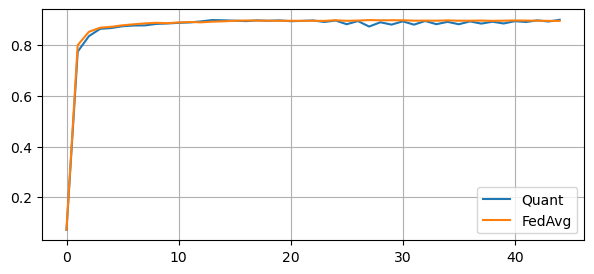

In [16]:
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')   
print(np.mean(percentage[:,0:44]))
print(np.mean(Bits[:,0:44]))